# Interpretando los modelos, conectando con humanos

## SHAP Values

Veremos brevemente un modelo de interpretabilidad para modelos complejos de machine learning como es un LGBM.

El uso de **python** para esta exploración se debe a la madurez encontrada en las librerías en mi búsqueda.

Empezamos con la instalación y carga de los módulos necesarios:

In [4]:
import pandas as pd
import numpy as np

try:
  import lightgbm as lgb
except:
  !pip install lightgbm
  import lightgbm as lgb
  
try:
  import shap
except:
  !pip install shap
  import shap

try:
  from umap import UMAP
except:
  !pip install umap
  !pip install umap-learn
  from umap import UMAP

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer


Cargamos el dataset. Vamos a trabajar con el primer conjunto de datos pero usted deberá utilizar un dataset ampliado y más refinado. Preparamos y separamos las clases y 

In [5]:
!pwd

/home/vbettachini/documents/universitet/FCEyN/maestríaDatos/economíaFinanzas/dmeyf2023/zweite


In [6]:
ds_train = pd.read_csv("../../datasets/competencia_01.csv")
# ds_train = pd.read_csv("/home/aleb/dmeyf23/datasets/competencia_01.csv")
clase_train = ds_train["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)

Y armamos un **dataset** con solo los casos de **BAJAS+1** y **BAJAS+2**. Sacamos los de los **datasets** los targets.

In [9]:
ds_bajas = ds_train.query("clase_ternaria != 'CONTINUA'")
ds_train = ds_train.drop(["clase_ternaria", "numero_de_cliente"], axis=1)
# ds_train = ds_train.drop("clase_ternaria", axis=1)
ds_bajas = ds_bajas.drop(["clase_ternaria", "numero_de_cliente"], axis=1)
# ds_bajas = ds_bajas.drop("clase_ternaria", axis=1)

Y hacemos un modelo **LGBM**. En este punto, usted agregue los mejores parámetros que haya encontrado.

In [10]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(ds_train, clase_train)

# specify your configurations as a dict
params = {
    'objective': 'binary',
    'learning_rate': 0.01,
    'verbose': 2,
    'max_bin': 15,
    'min_data_in_leaf': 500,
    'verbose': 0,
}

gbm = lgb.train(params, lgb_train, num_boost_round=100)
# calculamos las p para los clientes bajas (no me estoy preocupando del overfitting ni nada, algo quizás usted debiera)
p_bajas = gbm.predict(ds_bajas)

Hasta ahora, las herramientas para saber a que feature le daba importancia un modelo eran básicas. No era mucho más que un **feature importance**

In [11]:
lgbm_importancia = pd.DataFrame({'Features': gbm.feature_name(),
                        'Importances': gbm.feature_importance()})
lgbm_importancia.sort_values(by='Importances', inplace=True, ascending=False)
lgbm_importancia

,Features,Importances
0,foto_mes,463
106,ctrx_quarter,165
93,tcallcenter,151
126,Master_fechaalta,136
50,cpayroll_trx,130
...,...,...
65,mcajeros_propios_descuentos,0
64,ccajeros_propios_descuentos,0
63,mpagomiscuentas,0
62,cpagomiscuentas,0


Sin embargo podemos intuir que si un modelo detecta múltiples patrones, no todos los casos van a ser afectados por el mismo. Tiene sentido que dos clientes se den de baja por motivos distintos y que un modelo pondere para cada caso, un peso distinto a los **features**. O sea, necesitamos una forma de explicar de forma local (caso a caso) en vez de una global (para todos los casos). Para esto utilizaremos los modelos [SHAP](https://christophm.github.io/interpretable-ml-book/shap.html)  

Ahora avanzamos aplicando un modelo de interpretabilidad sobre el modelo anterior.

In [12]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(ds_bajas)
shap_bajas = pd.DataFrame(shap_values[0], columns = ds_bajas.columns)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


En la variable `shap_bajas` contaríamos para cada caso, el peso de la influencia de esa **feature** de acuerdo al modelo. Veamos un caso, tomemos un cliente:

In [13]:
# busco un caso en p_bajas, con un p alta, y tomo su índice
cliente_idx = 7 # el 
print(p_bajas[cliente_idx])

0.008558372846891434


En la columna de la izquierda es el valor de la variable, la importancia es la columna derecha.
Cuanto más positivo ese parámetro es más determinate a que se produzca la baja+2, uno negativo es que hace menos probable la baja.

In [14]:
df = pd.concat([ds_bajas.iloc[cliente_idx], shap_bajas.iloc[cliente_idx]], axis=1)
# pd.concat([ds_bajas.iloc[7], shap_bajas.iloc[7]], axis=1)
df.sort_values(by=[cliente_idx], ascending=False)

,618,7
ctrx_quarter,56.00,0.125811
mrentabilidad_annual,31990.93,0.108891
tcallcenter,0.00,0.043561
Master_fechaalta,749.00,0.042620
mpasivos_margen,1509.62,0.034816
...,...,...
Visa_mfinanciacion_limite,202694.40,-0.021947
mpayroll,0.00,-0.024392
foto_mes,202103.00,-0.035893
cpayroll_trx,0.00,-0.040703


En la tabla anterior, los **features** con números positivos "adicionan(*)" a la probabilidad y los negativos. 

(*) Aquí estamos usando TreeSHAP, que no es tan directa como Kernel SHAP para la interpretación directa. 

También podemos combinar todos los valores de SHAP y recrear una nueva importancia de variables:

In [13]:
shap_importancias = shap_bajas.abs().mean().sort_values(ascending=False)
shap_importancias

Master_fechaalta             0.901303
ctrx_quarter                 0.347815
foto_mes                     0.335814
Master_Fvencimiento          0.248255
Visa_mpagospesos             0.178368
                               ...   
mtransferencias_recibidas    0.000000
ctransferencias_recibidas    0.000000
mforex_sell                  0.000000
cforex_sell                  0.000000
mforex_buy                   0.000000
Length: 154, dtype: float64

La biblioteca contiene útiles herramientas para vizualizar la info anterior.

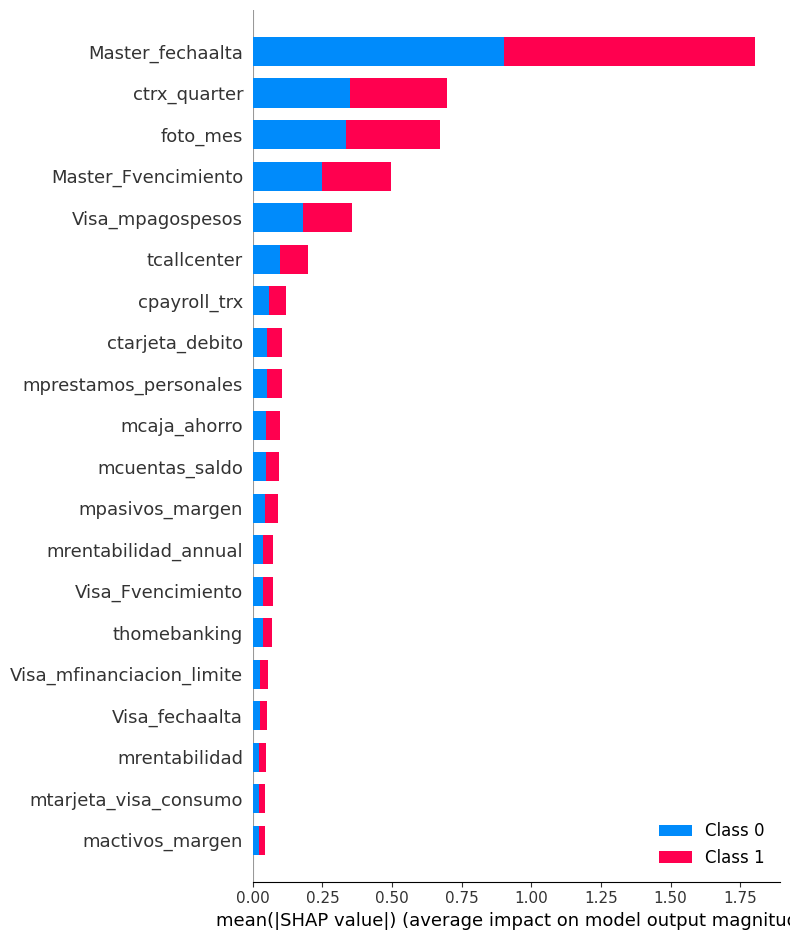

In [12]:
shap.summary_plot(shap_values, ds_bajas)

Y ahora debemos empezar a jugar para entender como estan asociadas las variables a los **shap values**

Para ver más opciones de visualización
https://www.youtube.com/watch?v=L8_sVRhBDLU&t=3s

## ¿Se podrá hacer una clusterización sobre los valores de shap?

Lo que estaríamos buscando es: "Juntar a todos los clientes que son afectamos por los mismos patrones del modelo, entendiendo que si les afecto el mismo patrón, sus SHAP van a ser similares." Presunción fuerte.
 
Como la cantidad de variables es muy alto, es conveniente hacer un embedding con **UMAP**. Por como es la estrutura de los **shap values** se pueden hacer sin mucho preprocesamiento. Usamos UMAP para estos embedding, https://www.youtube.com/watch?v=eN0wFzBA4Sc (triple BAM (?))

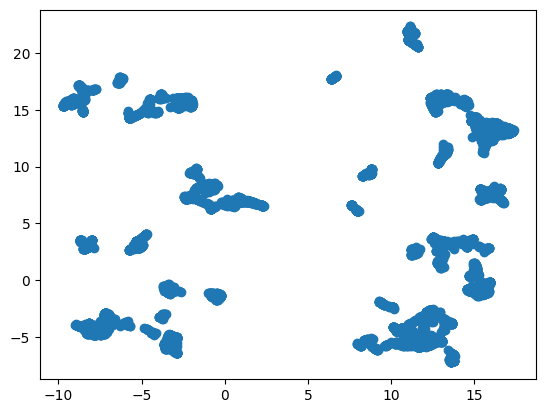

In [16]:
embedding_2d = UMAP(
  n_components=2, n_neighbors=40
).fit_transform(shap_values[0])
plt.scatter(embedding_2d[:,0], embedding_2d[:,1])

(array([3059.,  901.,  738.,  540.,  661.,  498.,  408.,  239.,   48.,
          36.]),
 array([0.00655302, 0.07101178, 0.13547054, 0.1999293 , 0.26438806,
        0.32884682, 0.39330558, 0.45776434, 0.5222231 , 0.58668186,
        0.65114062]),
 <BarContainer object of 10 artists>)

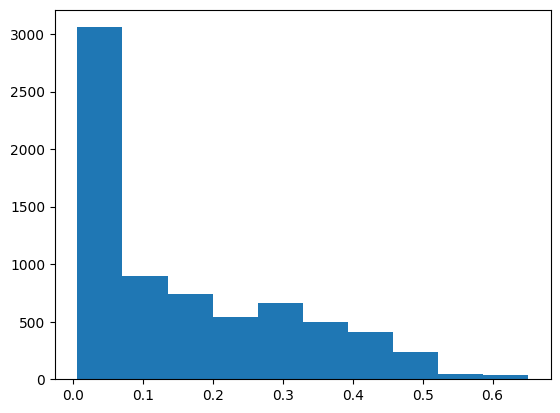

In [15]:
p_bajas = gbm.predict(ds_bajas)
plt.hist(p_bajas)

Su momento de brillar: Qué se puede hacer desde este punto para tratar de interpretar los distintos segmentos para la presentación de Miranda.

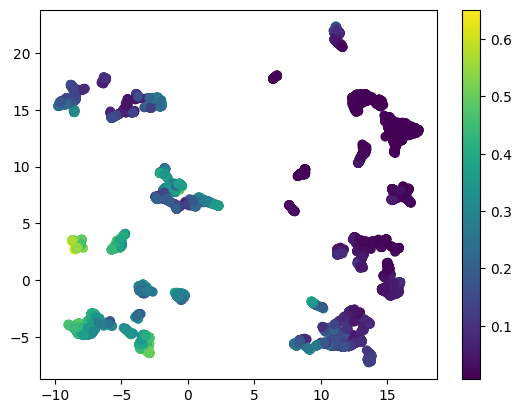

In [18]:
# mayor probabilidades de baja+2 mostrada en escala de colores
sc = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=p_bajas)
plt.colorbar(sc)
plt.show()

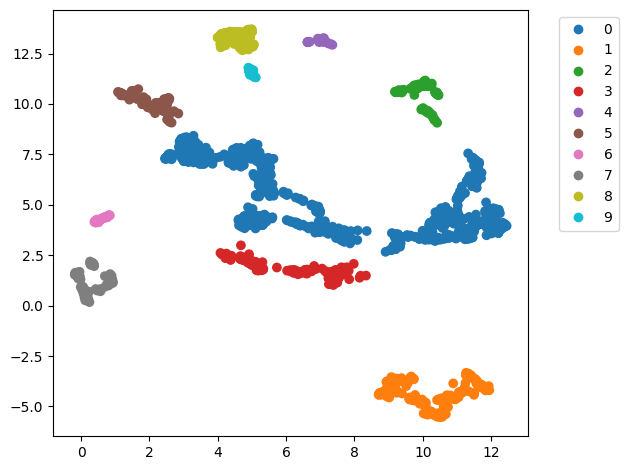

In [ ]:
hdb = DBSCAN(eps=0.75)
y = hdb.fit(embedding_2d)

plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=y.labels_, cmap='tab10')
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
shap_bajas[y.labels_ == 1].mean().sort_values(ascending=False)

chomebanking_transacciones    0.055489
thomebanking                  0.026331
cmobile_app_trx               0.011965
tcallcenter                   0.011174
Visa_Fvencimiento             0.010109
                                ...   
mcuentas_saldo               -0.247311
mtarjeta_visa_consumo        -0.301069
cdescubierto_preacordado     -0.508122
cpayroll_trx                 -0.683044
ctrx_quarter                 -1.357347
Length: 154, dtype: float64

In [ ]:
shap_bajas[y.labels_ == 6].mean().sort_values(ascending=False)

mprestamos_personales         1.000644
cprestamos_personales         0.240807
mrentabilidad_annual          0.064519
chomebanking_transacciones    0.030079
internet                      0.012880
                                ...   
mpayroll                     -0.140802
mcomisiones_mantenimiento    -0.222246
mtarjeta_visa_consumo        -0.278806
cpayroll_trx                 -0.318618
ctrx_quarter                 -0.976662
Length: 154, dtype: float64

In [ ]:
Xbajas.loc[y.labels_ == 1]["cprestamos_personales"].mean()

0.1383399209486166

In [ ]:
Xbajas.loc[y.labels_ == 6]["cprestamos_personales"].mean()

7.261904761904762

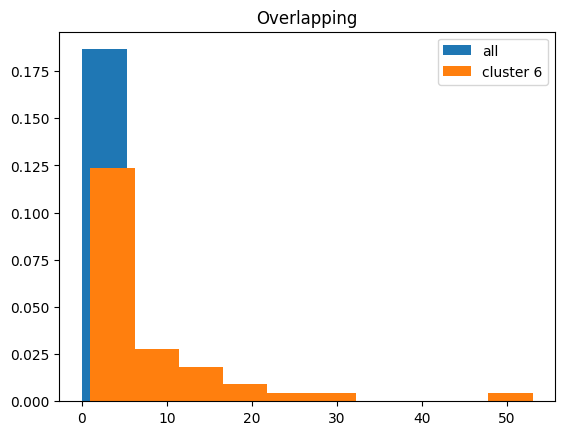

In [ ]:
plt.hist(Xbajas.loc[:]["cprestamos_personales"], label='all', density=True)
plt.hist(Xbajas.loc[y.labels_ == 6]["cprestamos_personales"], label='cluster 6', density=True)

plt.legend(loc='upper right')
plt.title('Overlapping')
plt.show()

## Random Forest distance

Armamos un conjunto de datos

In [ ]:
np.random.seed(17)
continua_sample = ytrain[ytrain == 0].sample(2000).index
bajas_1_2 = ytrain[ytrain == 1].index
rf_index = continua_sample.union(bajas_1_2)

In [ ]:
XRF = Xtrain.iloc[rf_index]
yRF = ytrain.iloc[rf_index]

In [ ]:
def distanceMatrix(model, X):

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    proxMat = proxMat / nTrees

    return proxMat.max() - proxMat


imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
XRF_imp = imp_mean.fit_transform(XRF)

model = RandomForestClassifier(n_estimators=100, max_features=20, min_samples_leaf=400, )
model.fit(XRF_imp, yRF)
d = distanceMatrix(model, XRF_imp)

Umap de rf

using precomputed metric; inverse_transform will be unavailable


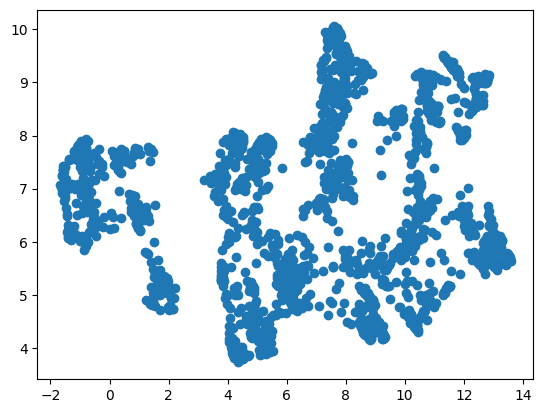

In [ ]:
embedding_rf = UMAP(
  n_components=2,
  n_neighbors=50,
  metric="precomputed",
).fit_transform(d[yRF==1,][:,yRF==1])

plt.scatter(embedding_rf[:,0], embedding_rf[:,1])